In [1]:
import geometric_kernels.torch 
import torch 
import gpytorch 
from torch import Tensor 
from mdgp.kernels import GeometricMaternKernel
from torch.func import jacfwd, vmap
from geometric_kernels.spaces import Hypersphere
from mdgp.utils import sphere_uniform_grid
from gpytorch.lazy import LazyEvaluatedKernelTensor


torch.set_default_dtype(torch.float64)
gpytorch.settings.debug._state = False

INFO: Using numpy backend


In [2]:
def flatten_matrix_valued_kernel(K: Tensor | LazyEvaluatedKernelTensor) -> Tensor: 
    """
    K: (..., N, M, D, D)
    return: (..., N * D, M * D)
    """
    if isinstance(K, LazyEvaluatedKernelTensor): 
        K = K.evaluate()
    return torch.cat(
        [torch.cat([block for block in row_of_blocks.unbind(-3)], dim=-1)
         for row_of_blocks in K.unbind(-4)], dim=-2
    )


def unflatten_matrix_valued_kernel(K: Tensor, d: int = 2) -> Tensor: 
    """
    K: (..., N * D, M * D)
    return: (..., N, M, D, D)
    """
    return torch.stack(
        [torch.stack([block for block in block_of_rows.split(d, dim=-1)], dim=-3)
        for block_of_rows in K.split(d, dim=-2)], dim=-4
    )


def test_flatten_matrix_valued_kernel(): 
    K = torch.randn(2, 5, 7, 3, 3)
    K_flat = flatten_matrix_valued_kernel(K)
    assert K_flat.shape == (2, 5 * 3, 7 * 3)
    for i in range(5): 
        for j in range(7): 
            assert torch.all(K[:, i, j] == K_flat[:, i * 3: (i + 1) * 3, j * 3: (j + 1) * 3])


def test_unflatten_matrix_valued_kernel():
    K = torch.randn(2, 5, 7, 3, 3)
    K_flat = flatten_matrix_valued_kernel(K)
    K_unflat = unflatten_matrix_valued_kernel(K_flat, d=3)
    assert torch.all(K_unflat == K)


test_flatten_matrix_valued_kernel()
test_unflatten_matrix_valued_kernel()

In [3]:
def broadcast_batch_shapes(*tensors: Tensor) -> torch.Size:
    """
    Given a list of tensors, returns the broadcasted batch shape.
    """
    return torch.broadcast_shapes(*[t.shape[:-2] for t in tensors])


def broadcast_batch_tensors(*tensors: Tensor) -> list[Tensor]:
    """
    Given a list of tensors, return a list of tensors with the same batch shape (if broadcastable).
    """
    batch_shape = broadcast_batch_shapes(*tensors)
    return [t.broadcast_to(*batch_shape, *t.shape[-2:]) for t in tensors]

# Numerically stable conversion between cartesian and spherical coordinates

In [4]:
def chart(sph: Tensor) -> Tensor: 
    """
    sph: (..., 2) with first dim longitude and second dim latitude
    return: (..., 3)
    """
    lat, lon = sph.unbind(-1)
    z = torch.sin(lat)
    r = torch.cos(lat) # small circle radius determined by z 
    x = r * torch.cos(lon)
    y = r * torch.sin(lon)
    return torch.stack((x, y, z), dim=-1)


def sph_to_car(sph: Tensor) -> Tensor:
    return chart(sph) 


def inverse_chart(car: Tensor) -> Tensor:
    x, y, z = car.unbind(-1)
    lat = torch.arcsin(z)
    lon = torch.atan2(y, x)
    return torch.stack((lat, lon), dim=-1)


def car_to_sph(car: Tensor, epsilon: float = 1e-10) -> Tensor:
    # car = jnp.atleast_2d(car)
    # assert car.ndim == 2 and car.shape[1] == 3
    north_pole = (car[:, 2] > 1 - epsilon)
    south_pole = (-car[:, 2] > 1 - epsilon)
    poles = north_pole | south_pole
    if poles.any():
        sph = torch.empty((*car.shape[:-1], 2), dtype=car.dtype)
        sph[~poles] = inverse_chart(car[~poles])
        sph[north_pole] = torch.tensor([torch.pi / 2, 0])
        sph[south_pole] = torch.tensor([-torch.pi / 2, 0])
    else:
        sph = inverse_chart(car)
    # some numerical issues can lead to NaNs when y=0, remediate here
    greenwich = (abs(car[:, 1]) < epsilon) & (~poles)
    if greenwich.any():
        sph[greenwich, 1] = torch.where(car[greenwich, 0] > 0, 0., torch.pi)
    return sph

# Projection on the tangent basis 

In [5]:
def tangent_basis_at(sph: Tensor) -> Tensor: 
    """
    sph: (2,)
    return: (3, 2)
    """
    f = jacfwd(chart)
    basis = f(sph)
    return basis / basis.norm(dim=-2, keepdim=True)


def tangent_basis_no_batch(sph: Tensor) -> Tensor: 
    """
    sph: (N, 2)
    return: (N, 3, 2)
    """
    f = vmap(tangent_basis_at)
    return f(sph)


def tangent_basis_batch(sph: Tensor) -> Tensor:
    """
    sph: (..., N, 2)
    return: (..., N, 3, 2)
    """
    f = vmap(tangent_basis_no_batch)
    return f(sph)

In [6]:
def grad_outer_grad(f): 
    return jacfwd(jacfwd(f, argnums=0), argnums=1)


def hodge_star_outer_hodge_star(grad_outer_grad: Tensor, x1: Tensor, x2: Tensor) -> Tensor: 
    """
    x1: (1, 3)
    x2: (1, 3)
    """
    return torch.linalg.cross(x2, torch.linalg.cross(x1, grad_outer_grad, dim=1).mT, dim=1)

In [7]:
from gpytorch.utils.memoize import cached 


class HodgeLazyEvaluatedKernelTensor(LazyEvaluatedKernelTensor):

    # @cached(name="size")
    def _size(self) -> torch.Size:
        size = super()._size()
        return torch.Size(size[:-2] + (size[-2] * 2, size[-1] * 2))

# TODO 
[X] Project the gradient onto the coordinate frame of the sphere. <br>
[ ] Implement a single-layer GP with the HodgeMaternKernel <br>
[ ] Run single-layer GP on the wind dataset 

In [8]:
from abc import ABC, abstractmethod
from gpytorch.kernels import Kernel
from geometric_kernels.kernels import MaternKarhunenLoeveKernel
from torch import Tensor
from gpytorch import settings 
import warnings 
from geometric_kernels.kernels.matern_kernel import feature_map_from_kernel
from mdgp.variational.spherical_harmonic_features.utils import num_harmonics


class HodgeMaternKernelBase(Kernel, ABC): 
    def __init__(self, scalar_matern_kernel, feature_map=None): 
        super().__init__()
        self.scalar_matern_kernel = scalar_matern_kernel
        self._feature_map = feature_map or feature_map_from_kernel(scalar_matern_kernel.geometric_kernel)

        # calculate the weights by which we need to divide the standard matern kernel before gradient 
        eigenvalues = torch.tensor(self.geometric_kernel.eigenvalues_laplacian)
        self._scalar_matern_kernel_weights = eigenvalues.repeat_interleave(num_harmonics(torch.arange(len(eigenvalues)), d=2)).sqrt()
    
    @property 
    def geometric_kernel(self) -> MaternKarhunenLoeveKernel: 
        return self.scalar_matern_kernel._kernel
    
    def weighted_scalar_feature_map_at(self, x: Tensor) -> Tensor:
        x = x.unsqueeze(0)
        params = self.scalar_matern_kernel.geometric_kernel_params
        features = self._feature_map(X=x, params=params)[1]
        weighted_features = features[..., 1:] / self._scalar_matern_kernel_weights[1:]
        return weighted_features.squeeze(0)

    def ambient_feature_map_coeffs(self, x: Tensor) -> Tensor:
        f = jacfwd(self.weighted_scalar_feature_map_at)
        if x.ndim == 1:
            return f(x)
        if x.ndim == 2:
            return vmap(f)(x)
        if x.ndim == 3:
            return vmap(vmap(f))(x)
        raise ValueError(f"x must have at most 3 dimensions, got {x.ndim}")
    
    def feature_map(self, x: Tensor) -> Tensor:
        tb = self.tangent_basis(car_to_sph(x)) # [..., 3, 2]
        ambient_coeffs = self.ambient_feature_map_coeffs(x) # [..., F, 3]
        tangent_coeffs = torch.einsum('...ij, ...fi -> ...jf', tb, ambient_coeffs) # [..., 2, F]
        return torch.einsum('...ij, ...jf -> ...if', tb, tangent_coeffs) # [..., 3, F]
    
    def sample(self, x: Tensor) -> Tensor:
        features = self.feature_map(x) 
        weights = torch.randn(features.shape[-1])
        return features @ weights
    
    def weighted_scalar_matern_kernel_at(self, x1: Tensor, x2: Tensor, diag: bool = False) -> Tensor: 
        """
        This takes in a single point x1 and x2 i.e.
        x1.shape = (1, 3)
        x2.shape = (1, 3)
        """
        params = self.scalar_matern_kernel.geometric_kernel_params
        # The only difference from standard kernel definition is division by the eigenvalues of the laplacian
        # print(self.geometric_kernel.eigenvalues(params))
        weights = self.geometric_kernel.eigenvalues(params)[1:] / torch.tensor(self.geometric_kernel.eigenvalues_laplacian)[1:]
        weights = torch.cat([torch.tensor([[0.]]), weights])
        Phi = self.geometric_kernel.eigenfunctions

        if diag is True: 
            K = Phi.weighted_outerproduct_diag(weights, x1, x2, **params)
        else:
            K = Phi.weighted_outerproduct(weights, x1, x2, **params)
        return K
    
    @abstractmethod
    def hodge_at(self, x1, x2) -> Tensor: 
        """
        x1.shape = (3,)
        x2.shape = (3,)
        """

    def hodge_no_batch(self, x1, x2): 
        """
        x1.shape = (N, 3)
        x2.shape = (M, 3)
        """
        f = vmap(vmap(self.hodge_at, in_dims=(None, 0)), in_dims=(0, None))
        return f(x1, x2)
    
    def hodge_batch(self, x1, x2): 
        """
        x1.shape = (B, N, 3)
        x2.shape = (B, M, 3)
        """
        f = vmap(self.hodge_no_batch)
        return f(x1, x2)
    
    def tangent_basis(self, sph: Tensor) -> Tensor: 
        """
        sph.shape = (..., 2)
        return: (..., 3, 2)
        """
        if sph.ndim == 1:
            return tangent_basis_at(sph)
        if sph.ndim == 2:
            return tangent_basis_no_batch(sph)
        if sph.ndim == 3:
            return tangent_basis_batch(sph)
        raise ValueError(f"sph must have at most 3 dimensions, got {sph.ndim}")

    def ambient_to_tangent_kernel(self, K_ambient: Tensor, x1: Tensor, x2: Tensor) -> Tensor: 
        """
        K_ambient.shape = (..., N, M, 3, 3)
        x1.shape = (..., N, 3)
        x2.shape = (..., M, 3)
        return: (..., N, M, 2, 2)
        """
        x1_sph = car_to_sph(x1)
        x2_sph = car_to_sph(x2)

        # Project kernel onto S^2 tangent space 
        tangent_basis_x1 = self.tangent_basis(x1_sph) # (..., N, 3, 2)
        tangent_basis_x2 = self.tangent_basis(x2_sph) # (..., M, 3, 2)
        # (..., N, 3, 2) @ (..., N, M, 3, 3) @ (..., M, 3, 2) -> (..., N, M, 2, 2)
        K_tangent = torch.einsum('...nji, ...nmjk, ...mkl -> ...nmil', tangent_basis_x1, K_ambient, tangent_basis_x2)
        return K_tangent
    
    def forward_(self, x1: Tensor, x2: Tensor) -> Tensor:
        """
        x1.shape = (..., N, 3)
        x2.shape = (..., M, 3)
        return: (..., N, M, 3, 3)
        """
        # TODO Currently we don't support broadcasting over batch dimensions. 
        # This introduces some redundant computation. 
        x1, x2 = broadcast_batch_tensors(x1, x2)

        # Get kernel with cartesian gradient (embedded field kernel)
        # K_cart.shape = (..., N, M, 3, 3)
        if x1.ndim == 1: 
            K_cart = self.hodge_at(x1, x2)
        if x1.ndim == 2:
            K_cart = self.hodge_no_batch(x1, x2)
        if x1.ndim == 3:
            K_cart = self.hodge_batch(x1, x2)
        
        # Project kernel onto S^2 tangent space 
        K_tangent = self.ambient_to_tangent_kernel(K_cart, x1, x2)
        return K_tangent         

    def forward(self, x1, x2, diag: bool = False, last_dim_is_batch: bool = False) -> Tensor:
        """
        x1.shape = (..., N, 3)
        x2.shape = (..., M, 3)
        return: (..., N, M, 3, 3)
        """

        if x2 is None: 
            x2 = x1
        K = self.forward_(x1, x2)
        K = flatten_matrix_valued_kernel(K)
        if diag is True: 
            K = K.diagonal(dim1=-2, dim2=-1)
        return K 
    
    def __call__(self, x1: Tensor, x2: Tensor = None, diag: bool = False, last_dim_is_batch: bool = False) -> Tensor: 
        res = super().__call__(x1, x2, diag=diag, last_dim_is_batch=last_dim_is_batch)
        if isinstance(res, LazyEvaluatedKernelTensor): 
            return HodgeLazyEvaluatedKernelTensor(x1=res.x1, x2=res.x2, kernel=res.kernel, last_dim_is_batch=res.last_dim_is_batch, **res.params)
        return res 

class CurlFreeHodgeMaternKernel(HodgeMaternKernelBase): 
    def hodge_at(self, x1: Tensor, x2: Tensor) -> Tensor: 
        x1 = x1.unsqueeze(0)
        x2 = x2.unsqueeze(0)
        return grad_outer_grad(self.weighted_scalar_matern_kernel_at)(x1, x2).squeeze()
    

class DivFreeHodgeMaternKernel(HodgeMaternKernelBase): 
    def hodge_at(self, x1: Tensor, x2: Tensor) -> Tensor: 
        x1 = x1.unsqueeze(0)
        x2 = x2.unsqueeze(0)
        dd = grad_outer_grad(self.weighted_scalar_matern_kernel_at)(x1, x2).squeeze()
        return hodge_star_outer_hodge_star(grad_outer_grad=dd, x1=x1, x2=x2)
    
    def sample(self, x: Tensor) -> Tensor:
        f = super().sample(x)
        return torch.linalg.cross(x, f, dim=-1)
    

class HodgeMaternKernel(HodgeMaternKernelBase): 
    def hodge_at(self, x1: Tensor, x2: Tensor) -> Tensor: 
        x1 = x1.unsqueeze(0)
        x2 = x2.unsqueeze(0)
        dd = grad_outer_grad(self.weighted_scalar_matern_kernel_at)(x1, x2).squeeze()
        sdsd = hodge_star_outer_hodge_star(grad_outer_grad=dd, x1=x1, x2=x2)
        return dd + sdsd 
    
    def sample(self, x: Tensor) -> Tensor:
        f1 = super().sample(x)
        f2 = super().sample(x)
        f2 = torch.linalg.cross(x, f2, dim=-1)
        return f1 + f2

In [9]:
gpytorch.kernels.AdditiveKernel()

AdditiveKernel(
  (kernels): ModuleList()
)

In [10]:
nx = 13
ny = 17
num_batches = 5
space = Hypersphere(2)
x = sphere_uniform_grid(nx * num_batches).reshape(num_batches, nx, 3)
y = sphere_uniform_grid(ny * num_batches).reshape(num_batches, ny, 3)
base_kernel = GeometricMaternKernel(space=space, num_eigenfunctions=25, lengthscale=1.0, nu=2.5)
hodge_kernel = DivFreeHodgeMaternKernel(base_kernel)
print(hodge_kernel(x, y).evaluate().shape)

torch.Size([5, 26, 34])


In [43]:
def get_kernel(name='full', num_eigenfunctions=25):
    scalar_matern_kernel = GeometricMaternKernel(space=space, num_eigenfunctions=num_eigenfunctions, lengthscale=1.0, nu=2.5)
    if name == 'full':
        kernel = HodgeMaternKernel(scalar_matern_kernel)
    elif name == 'div':
        kernel = CurlFreeHodgeMaternKernel(scalar_matern_kernel)
    elif name == 'curl':
        kernel = DivFreeHodgeMaternKernel(scalar_matern_kernel)
    return kernel


def ambient_objective(x: Tensor) -> Tensor:
    """
    x: Tensor of coordinates on the sphere (..., 2)
    return: values of the vector field 
    """
    def f(x: Tensor) -> Tensor: 
        return x[..., 2]
    return vmap(jacfwd(f))(x)


def tangent_objective_coeff(x: Tensor) -> Tensor: 
    ambient = ambient_objective(x)
    tb = tangent_basis_no_batch(car_to_sph(x))
    return torch.einsum('...ji, ...j -> ...i', tb, ambient)


def coeff_to_tangent(coeff: Tensor, x: Tensor) -> Tensor: 
    tb = tangent_basis_no_batch(car_to_sph(x))
    return torch.einsum('...ji, ...i -> ...j', tb, coeff)


def tangent_objective(x: Tensor) -> Tensor:
    coeff = tangent_objective_coeff(x)
    return coeff_to_tangent(coeff, x)


def sample(kernel: HodgeMaternKernelBase, x):
    features = kernel.feature_map(x)
    weights = torch.randn(features.shape[-1])
    return features @ weights

# Prior samples

In [42]:
from mdgp.utils import sphere_uniform_grid, sphere_meshgrid
from plotly import graph_objects as go


def plot_sample(name='full', n=200):        
    kernel = get_kernel(name)

    with torch.no_grad():
        xyz = sphere_uniform_grid(n)
        x, y, z = xyz.unbind(-1)
        u, v, w = kernel.sample(xyz).unbind(-1)
        x_mesh, y_mesh, z_mesh = sphere_meshgrid(25, 25).unbind(-1)


    fig = go.Figure()
    fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh))
    fig.add_trace(go.Cone(x=x, y=y, z=z, u=u, v=v, w=w, colorscale=['black', 'black'], showscale=False, sizeref=0.5))
    fig.update_layout(
        height=600, width=600
    )
    fig.show()


plot_sample('full'), plot_sample('div'), plot_sample('curl');

# Visualise kernels in accordance with paper

In [12]:
# "center" point
y_sph = torch.tensor([[0, torch.pi]])
# vector at center
v_y_sph = torch.tensor([[0., 1.]])
y_car = sph_to_car(y_sph)

# mesh for plotting
n_lat, n_lon = 25, 25

lat = torch.linspace(-torch.pi / 2 + .001, torch.pi / 2 - .001, n_lat)
lon = torch.linspace(0, 2 * torch.pi, n_lon)

lat_mesh, lon_mesh = torch.meshgrid(lat, lon, indexing='xy')
mesh_shape = lat_mesh.shape
lat, lon = lat_mesh.flatten(), lon_mesh.flatten()
sph_coord = torch.stack([lat, lon]).T
car_coord = sph_to_car(sph_coord)

In [13]:
def plot_kernel(name='full'):
    kernel = get_kernel(name)
    
    with torch.no_grad():
        k_hodge_flat = kernel(car_coord, y_car)
        # const = kernel_hodge(y_car)[0, 0]
        v_x_hodge = (k_hodge_flat @ v_y_sph.mT).reshape(-1, 2) #/ const


    from matplotlib import pyplot as plt 


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
    hodge_lat, hodge_lon = v_x_hodge.unbind(-1)
    # hodge
    ax.quiver(lon, lat, hodge_lon, hodge_lat, angles="uv")
    ax.quiver([y_sph[:, 1]], [y_sph[:, 0]], v_y_sph[:, 1], v_y_sph[:, 0], angles="uv", color="red")
    ax.set_xlabel("lon")
    ax.set_ylabel("lat")
    ax.set_title(f"Hodge kernel: {name}")
    fig.show()

/tmp/ipykernel_245890/4008155736.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



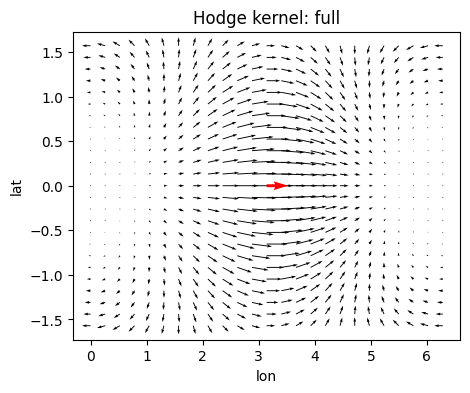

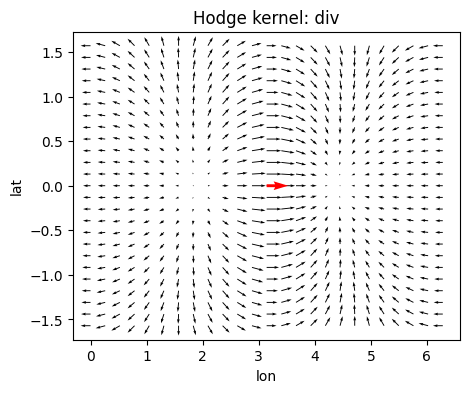

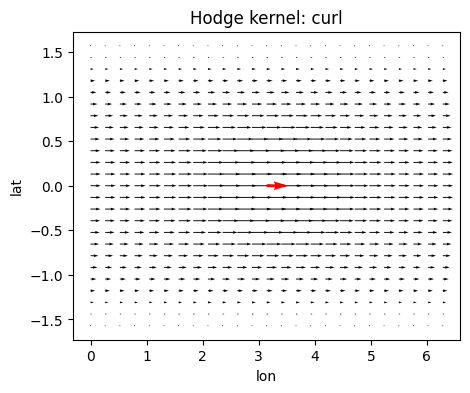

In [14]:
plot_kernel('full'), plot_kernel('div'), plot_kernel('curl');

# Fit kernel exactly

In [15]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.covar_module = kernel

    def forward(self, x):
        mean = torch.zeros(*x.shape[:-2], x.shape[-2] * 2)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [16]:
from mdgp.utils import sphere_uniform_grid, sphere_meshgrid
from plotly import graph_objects as go


with torch.no_grad():
    xyz = sphere_uniform_grid(100)
    x, y, z = xyz.unbind(-1)
    u, v, w = tangent_objective(xyz).unbind(-1)
    x_mesh, y_mesh, z_mesh = sphere_meshgrid(25, 25).unbind(-1)


fig = go.Figure()
fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh))
fig.add_trace(go.Cone(x=x, y=y, z=z, u=u, v=v, w=w, sizeref=0.1))
fig.show()

Optimize the Exact Hodge GP to the data above

In [72]:
train_x = sphere_uniform_grid(50)
u = torch.linspace(0, 2 * torch.pi, 50)
train_x = torch.stack([torch.cos(u), torch.sin(u), torch.zeros_like(u)], dim=-1)
train_y = tangent_objective_coeff(train_x).flatten(-2, -1)


base_kernel = get_kernel('div', num_eigenfunctions=3)
kernel = base_kernel
kernel = gpytorch.kernels.ScaleKernel(base_kernel)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

gp = ExactGPModel(train_x, train_y, likelihood, kernel)


from tqdm.autonotebook import tqdm 


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)
optimizer = torch.optim.Adam(gp.parameters(), lr=0.01, maximize=True)
gp.train()
likelihood.train()

pbar = tqdm(range(100))
with settings.lazily_evaluate_kernels(False):
    for i in pbar:
        optimizer.zero_grad()
        output = gp(train_x)
        loss = mll(output, train_y)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

In [73]:
from mdgp.utils import sphere_uniform_grid, sphere_meshgrid
from plotly import graph_objects as go
from plotly.subplots import make_subplots


with torch.no_grad(), settings.lazily_evaluate_kernels(False):
    gp.eval()
    xyz = sphere_uniform_grid(400)
    x, y, z = xyz.unbind(-1)
    out = gp(xyz)
    coeff = out.mean.reshape(-1, 2)
    u, v, w = coeff_to_tangent(coeff, xyz).unbind(-1)
    u_obj, v_obj, w_obj = tangent_objective(xyz).unbind(-1)
    xyz_mesh = sphere_meshgrid(25, 25)
    x_mesh, y_mesh, z_mesh = xyz_mesh.unbind(-1)
    stddev = gp(xyz_mesh.view(-1, 3)).stddev.reshape(-1, 2).norm(dim=-1).reshape(25, 25)


fig = make_subplots(rows=1, cols=4, specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]], 
                    subplot_titles=['Mean', 'STD', 'Objective', 'Mean - Objective'])

fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh), row=1, col=1)
fig.add_trace(go.Cone(x=x, y=y, z=z, u=u, v=v, w=w, sizeref=0.1, colorscale=['black', 'black'], showscale=False), row=1, col=1)
fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh, surfacecolor=stddev, colorscale='viridis'), row=1, col=2)
fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh), row=1, col=3)
fig.add_trace(go.Cone(x=x, y=y, z=z, u=u_obj, v=v_obj, w=w_obj, sizeref=0.1, colorscale=['black', 'black'], showscale=False), row=1, col=3)
fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh), row=1, col=4)
fig.add_trace(go.Cone(x=x, y=y, z=z, u=u - u_obj, v=v - v_obj, w=w - w_obj, sizeref=0.1, colorscale=['black', 'black'], showscale=False), row=1, col=4)

fig.show()

: 

In [69]:
train_x = sphere_uniform_grid(50)
u = torch.linspace(0, 2 * torch.pi, 50)
train_x = torch.stack([torch.cos(u), torch.sin(u), torch.zeros_like(u)], dim=-1)
train_y = tangent_objective_coeff(train_x).flatten(-2, -1)


base_kernel = get_kernel('curl', num_eigenfunctions=3)
kernel = base_kernel
kernel = gpytorch.kernels.ScaleKernel(base_kernel)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

gp = ExactGPModel(train_x, train_y, likelihood, kernel)


from tqdm.autonotebook import tqdm 


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)
optimizer = torch.optim.Adam(gp.parameters(), lr=0.01, maximize=True)
gp.train()
likelihood.train()

pbar = tqdm(range(100))
with settings.lazily_evaluate_kernels(False):
    for i in pbar:
        optimizer.zero_grad()
        output = gp(train_x)
        loss = mll(output, train_y)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

In [71]:
from mdgp.utils import sphere_uniform_grid, sphere_meshgrid
from plotly import graph_objects as go
from plotly.subplots import make_subplots


with torch.no_grad(), settings.lazily_evaluate_kernels(False):
    gp.eval()
    xyz = sphere_uniform_grid(400)
    x, y, z = xyz.unbind(-1)
    out = gp(xyz)
    coeff = out.mean.reshape(-1, 2)
    u, v, w = coeff_to_tangent(coeff, xyz).unbind(-1)
    u_obj, v_obj, w_obj = tangent_objective(xyz).unbind(-1)
    xyz_mesh = sphere_meshgrid(25, 25)
    x_mesh, y_mesh, z_mesh = xyz_mesh.unbind(-1)
    stddev = gp(xyz_mesh.view(-1, 3)).stddev.reshape(-1, 2).norm(dim=-1).reshape(25, 25)


fig = make_subplots(rows=1, cols=4, specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]], 
                    subplot_titles=['Mean', 'STD', 'Objective', 'Mean - Objective'])

fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh), row=1, col=1)
fig.add_trace(go.Cone(x=x, y=y, z=z, u=u, v=v, w=w, sizeref=0.1, colorscale=['black', 'black'], showscale=False), row=1, col=1)
fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh, surfacecolor=stddev, colorscale='viridis'), row=1, col=2)
fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh), row=1, col=3)
fig.add_trace(go.Cone(x=x, y=y, z=z, u=u_obj, v=v_obj, w=w_obj, sizeref=0.1, colorscale=['black', 'black'], showscale=False), row=1, col=3)
fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh), row=1, col=4)
fig.add_trace(go.Cone(x=x, y=y, z=z, u=u - u_obj, v=v - v_obj, w=w - w_obj, sizeref=0.1, colorscale=['black', 'black'], showscale=False), row=1, col=4)

fig.show()

In [30]:
train_x = sphere_uniform_grid(150)
train_y = tangent_objective_coeff(train_x).flatten(-2, -1)


base_kernel = get_kernel('div')
kernel = base_kernel
kernel = gpytorch.kernels.ScaleKernel(base_kernel)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

gp = ExactGPModel(train_x, train_y, likelihood, kernel)


from tqdm.autonotebook import tqdm 


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)
optimizer = torch.optim.Adam(gp.parameters(), lr=0.01, maximize=True)
gp.train()
likelihood.train()

pbar = tqdm(range(100))
with settings.lazily_evaluate_kernels(False):
    for i in pbar:
        optimizer.zero_grad()
        output = gp(train_x)
        loss = mll(output, train_y)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
from mdgp.utils import sphere_uniform_grid, sphere_meshgrid
from plotly import graph_objects as go
from plotly.subplots import make_subplots


with torch.no_grad(), settings.lazily_evaluate_kernels(False):
    gp.eval()
    xyz = sphere_uniform_grid(400)
    x, y, z = xyz.unbind(-1)
    out = gp(xyz)
    coeff = out.mean.reshape(-1, 2)
    u, v, w = coeff_to_tangent(coeff, xyz).unbind(-1)
    u_obj, v_obj, w_obj = tangent_objective(xyz).unbind(-1)
    xyz_mesh = sphere_meshgrid(25, 25)
    x_mesh, y_mesh, z_mesh = xyz_mesh.unbind(-1)
    stddev = gp(xyz_mesh.view(-1, 3)).stddev.reshape(-1, 2).norm(dim=-1).reshape(25, 25)


fig = make_subplots(rows=1, cols=4, specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]], 
                    subplot_titles=['Mean', 'STD', 'Objective', 'Mean - Objective'])

fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh), row=1, col=1)
fig.add_trace(go.Cone(x=x, y=y, z=z, u=u, v=v, w=w, sizeref=0.1, colorscale=['black', 'black'], showscale=False), row=1, col=1)
fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh, surfacecolor=stddev, colorscale='viridis'), row=1, col=2)
fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh), row=1, col=3)
fig.add_trace(go.Cone(x=x, y=y, z=z, u=u_obj, v=v_obj, w=w_obj, sizeref=0.1, colorscale=['black', 'black'], showscale=False), row=1, col=3)
fig.add_trace(go.Surface(x=x_mesh, y=y_mesh, z=z_mesh), row=1, col=4)
fig.add_trace(go.Cone(x=x, y=y, z=z, u=u - u_obj, v=v - v_obj, w=w - w_obj, sizeref=0.1, colorscale=['black', 'black'], showscale=False), row=1, col=4)

fig.show()

# Inducing points 

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.covar_module = kernel

    def forward(self, x):
        mean = torch.zeros(*x.shape[:-2], x.shape[-2] * 2)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)